## Setup

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import lightning.pytorch as pl
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import re
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.metrics.distributions import MQF2DistributionLoss
from pytorch_forecasting import TimeSeriesDataSet

# For plotting
from sklearn.neighbors import KernelDensity
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
torch.cuda.empty_cache()

# Paths, lags and lead, time index (weekly resolution)
BASE_PATH = 'D:/KIMoDIs/global-groundwater-models-main'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULT_PATH = os.path.join(BASE_PATH, 'results')
FIGURES_PATH = os.path.join(BASE_PATH, 'figures')
SHARE_PATH = 'J:/Berlin/B22-FISHy/NUTZER/Kunz.S'

LAG = 52  # weeks
LEAD = 12  # weeks

# Roughly 80/10/10
TRAIN_PERIOD = (pd.Timestamp(1990, 1, 1), pd.Timestamp(2012, 1, 1))
VAL_PERIOD = (pd.Timestamp(2010, 1, 1), pd.Timestamp(2013, 1, 1))
TEST_PERIOD = (pd.Timestamp(2012, 1, 1), pd.Timestamp(2016, 1, 1))

TIME_IDX = pd.date_range(TRAIN_PERIOD[0], TEST_PERIOD[1], freq='W-SUN', inclusive='neither', name='time').to_frame().reset_index(drop=True)
TIME_IDX.index.name = 'time_idx'
TIME_IDX = TIME_IDX.reset_index()

D:\KIMoDIs\GGWM\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Change the model type here
MODEL_TYPE = 'dyn'
VERSION = '10_Epochs'

In [3]:
FONT_SIZE = 18
col_grey ='#bababa'

# plt.style.use('seaborn-v0_8')
sns.set(rc=
    {"font.size": FONT_SIZE,
     "axes.titlesize": FONT_SIZE,
     "axes.labelsize": FONT_SIZE,
     "xtick.labelsize": FONT_SIZE-2,
     "ytick.labelsize": FONT_SIZE-2,
     "legend.fontsize": FONT_SIZE-2,
     "legend.title_fontsize": FONT_SIZE-2,
    }
)
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': FONT_SIZE,
    'axes.labelsize':FONT_SIZE-2,
    'axes.labelweight': 'bold',
    'axes.titleweight':'bold',
    
    'legend.fontsize': FONT_SIZE-2,
    'legend.title_fontsize': FONT_SIZE-2,
    
    'axes.facecolor': 'white',
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'major',
    'grid.linestyle': '--',
    'grid.color': 'gray',
    'grid.linewidth': '0.5',
    
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    
    'savefig.bbox':'tight',
    'savefig.dpi':300
})

## Data preparation
Loading of training & test data. Test data are subset to the sites that have been used during training (in sample setting).

A TimeSeriesDataSet for the test data is generated from the train_ds, i.e. a dataset with different underlying
data but the same variable encoders and scalers as the training data.

I also included a code block to randomly select a certain number of test sites in case of performance problems.

In [4]:
train_df = pq.read_table(os.path.join(SHARE_PATH, 'kimodis_preprocessed', 'train_df.parquet'))
train_df = train_df.to_pandas()
val_df = pq.read_table(os.path.join(SHARE_PATH, 'kimodis_preprocessed', 'val_df.parquet'))
val_df = val_df.to_pandas()
test_df = pq.read_table(os.path.join(SHARE_PATH, 'kimodis_preprocessed', 'test_df.parquet'))
test_df = test_df.to_pandas()

test_df_in_sample = test_df[test_df['proj_id'].isin(train_df['proj_id'].unique())]

In [5]:
test_df_in_sample = test_df[test_df['proj_id'].isin(train_df['proj_id'].unique())]
test_df_out_sample = test_df[~test_df['proj_id'].isin(train_df['proj_id'].unique())]

In [6]:
# sites_in_sample = test_df_in_sample['proj_id'].unique()
# np.random.seed(42)
# sites_in_sample = np.random.choice(sites_in_sample, size=100, replace=False)
# test_df_in_sample = test_df_in_sample[test_df_in_sample['proj_id'].isin(sites_in_sample)]
print('There are', len(test_df_in_sample['proj_id'].unique()), 'test sites (in sample setting).')

There are 5308 test sites (in sample setting).


In [7]:
# TimeSeriesDataSet for training data
train_ds = TimeSeriesDataSet.load(os.path.join(SHARE_PATH, 'kimodis_preprocessed', f'train_ds_{MODEL_TYPE}_nhits.pt'))

## Making predictions

`mode='raw'`

The raw predictions are a dictionary from which all kind of information including quantiles can be extracted (if specified in the loss function).
Returns a prediction tuple with pytorch tensors. 
Shape of the `raw_predictions['prediction']` tensor: [n, horizons, 1 or number of quantiles if defined] 

`return_x=True`

Returns network inputs including the encoder/decoder lengths.

`return_index=True`

Returns a pandas df with time indices and groups (i.e. proj_ids) that can be matched with the predictions 
(object index has the same order as the output).

Docs:
https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.base_model.BaseModel.html#pytorch_forecasting.models.base_model.BaseModel.predict

In [8]:
# Create TimeSeries object
test_ds_in_sample = TimeSeriesDataSet.from_dataset(train_ds, test_df_in_sample) 
test_dataloader_in_sample = test_ds_in_sample.to_dataloader(train=False, batch_size=512, num_workers=0)

In [9]:
# path to all tft models speciefied by MODEL_TYPE and VERSION
folder = os.path.join(
        MODEL_PATH, 
       'nhits', 
       f'nhits_{MODEL_TYPE}',
       f'nhits_{MODEL_TYPE}_1024_{VERSION}')

# list of different versions
mod_init = [name for name in os.listdir(folder) if re.match('version.*', name)]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []
Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []
Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []
Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []
Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []
Empty DataFrame
Columns: [proj_id, time, horizon, forecast]
Index: []


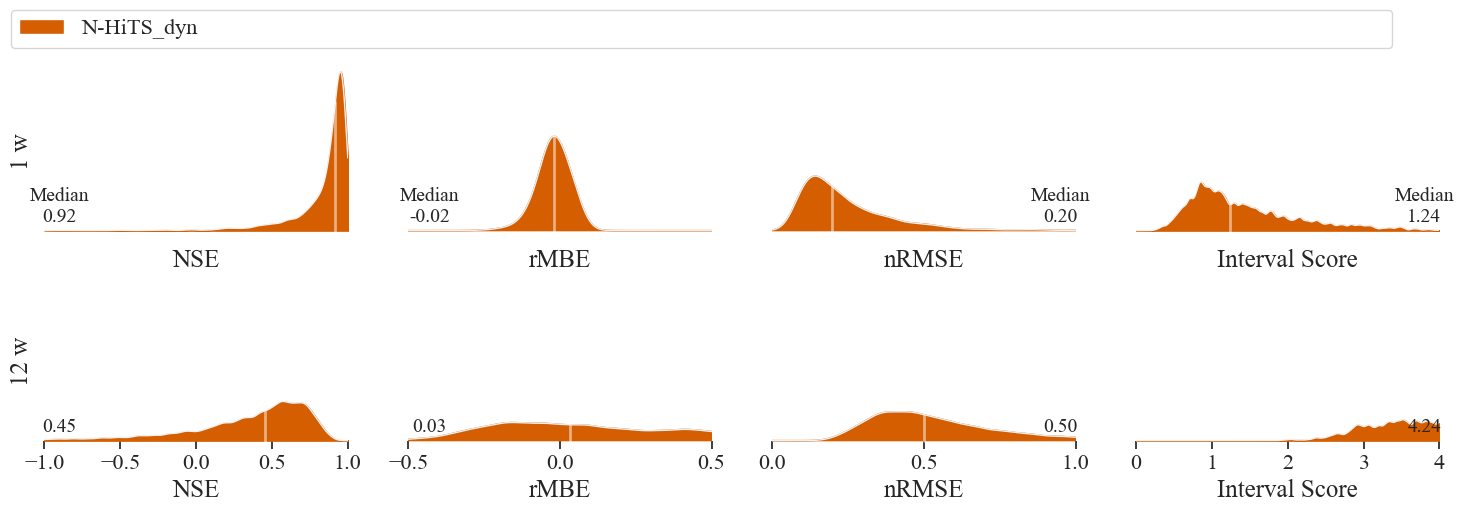

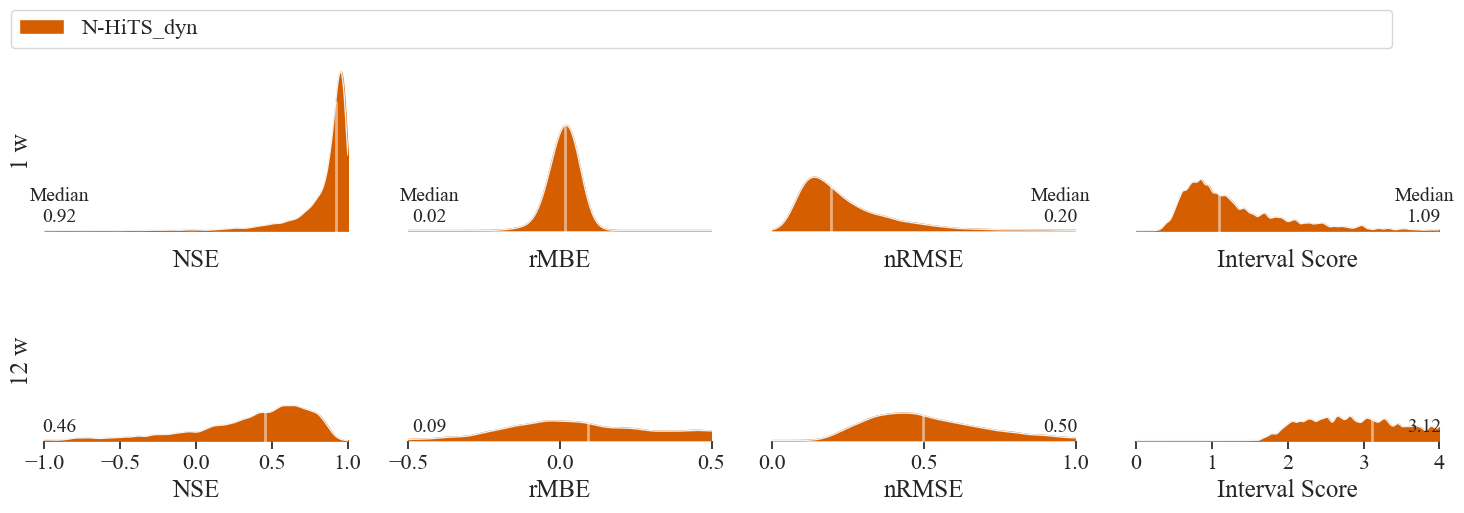

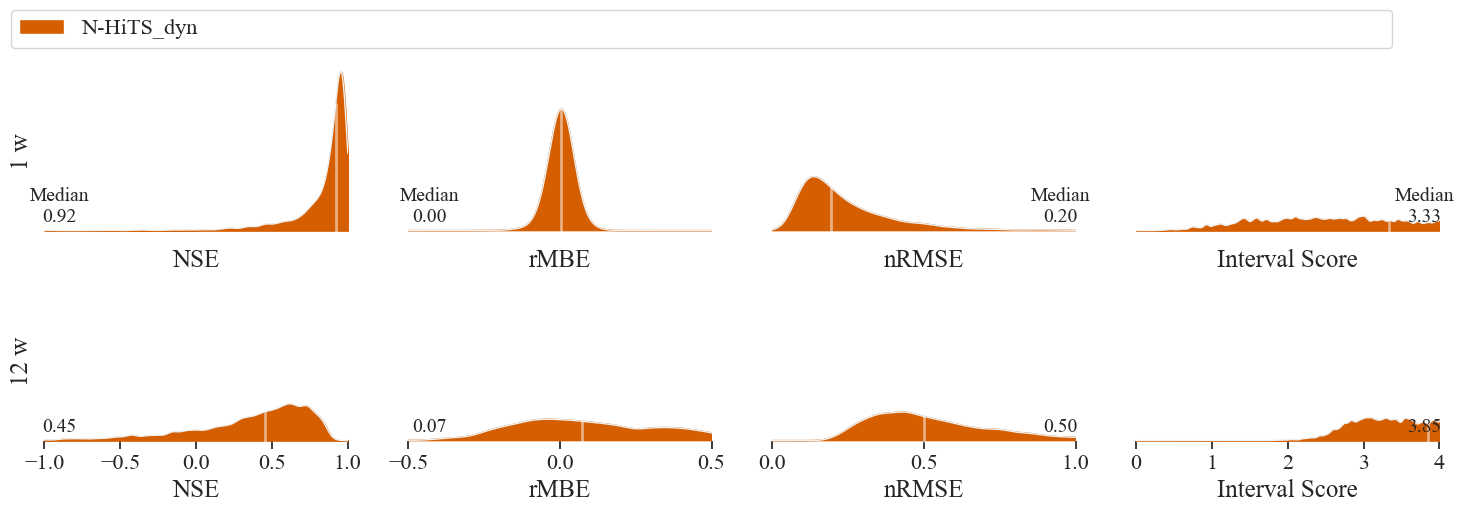

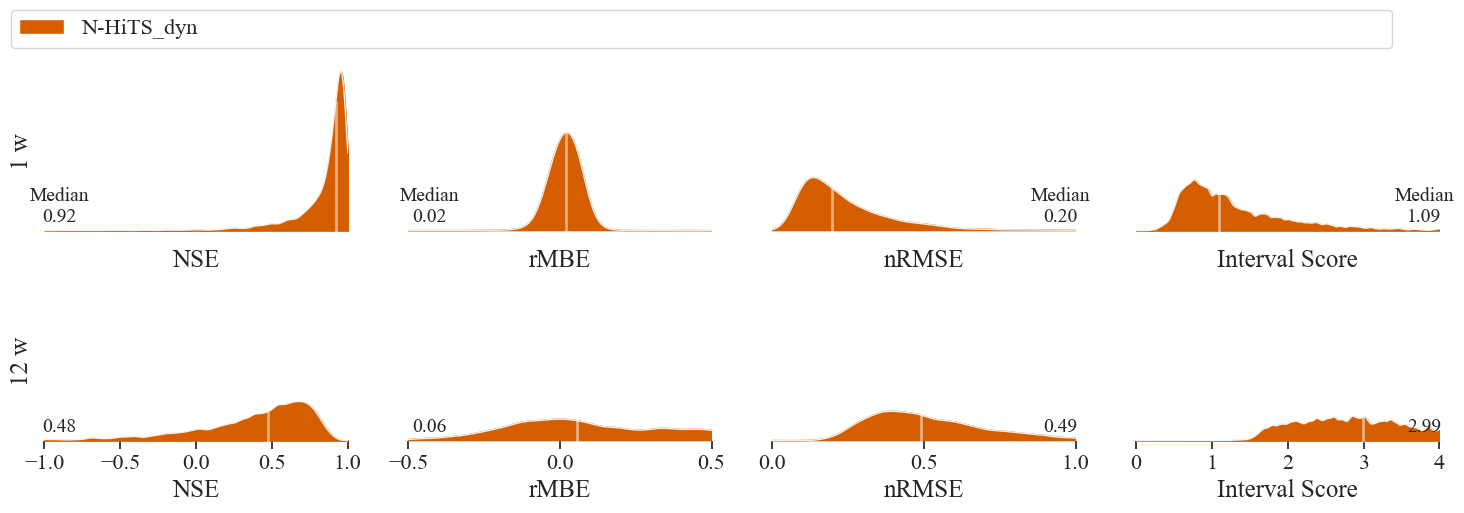

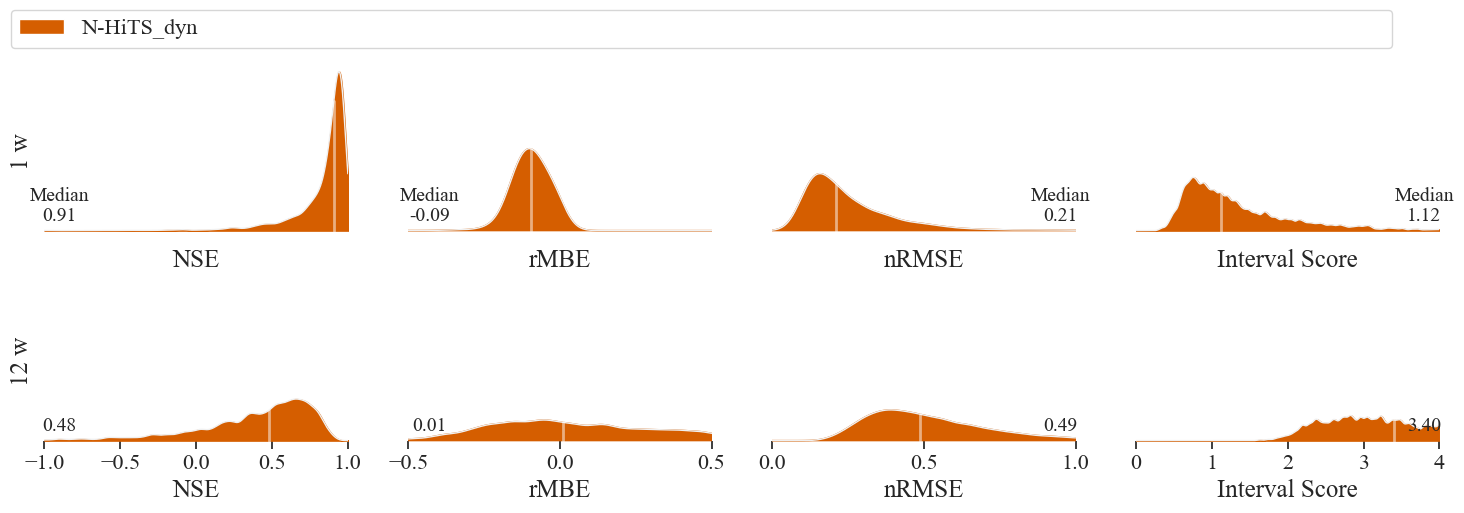

In [12]:
for init in mod_init: 
    
    # Get the different model objects 
    sub_folder = os.path.join(folder, init, 'checkpoints')
    mod_name = [name for name in os.listdir(sub_folder) if re.match('epoch.*', name)] # would suffice: os.listdir(sub_folder)[0]
    
    model = NHiTS.load_from_checkpoint(os.path.join(sub_folder, mod_name[0]))
    
    # Docs: 
    # https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.base_model.BaseModel.html#pytorch_forecasting.models.base_model.BaseModel.predict
    # Calculate predictions with newly trained model
    predictions, x, index, y, decoder = model.predict(test_dataloader_in_sample, 
                                                      mode='quantiles',
                                                      return_index=True, 
                                                      # return_decoder_lengths=True,
                                                      trainer_kwargs=dict(accelerator='cpu', 
                                                                          devices=1))
    
    ### Assess Predictions #####################################################################################
    predictions = predictions.numpy()
    
    from utils import predictions_to_df

    # Check for duplicates in the predictions
    nhits_pred = predictions_to_df(index, np.transpose(predictions, (2, 1, 0))[3], ['proj_id'], TIME_IDX, LEAD)
    nhits_pred.reset_index(inplace=True)
    print(nhits_pred[nhits_pred.duplicated(subset=['proj_id', 'time', 'horizon'])])
    # Check for NANs
    print(nhits_pred[nhits_pred['forecast'].isnull()])
    
    nhits_pred = predictions_to_df(index, np.transpose(predictions, (2, 1, 0))[3], ['proj_id'], TIME_IDX, LEAD)
    # Extract quantiles
    for q_idx, q_name in [(0, '02'), (1, '10'), (2, '25'), (4, '75'), (5, '90'), (6, '98')]:
        q_df = predictions_to_df(index, np.transpose(predictions, (2, 1, 0))[q_idx], ['proj_id'], TIME_IDX, LEAD)
        nhits_pred[f'forecast_q{q_name}'] = q_df['forecast'].values

    # Merge ground truth
    nhits_pred = nhits_pred.reset_index().merge(test_df_in_sample[['proj_id', 'time', 'gwl']], on=['proj_id', 'time'], how='left').set_index(['proj_id', 'time', 'horizon'])
    nhits_pred.reset_index().to_feather(os.path.join(RESULT_PATH, 
                                                     'predictions',
                                                     'nhits',
                                                     f'nhits_{MODEL_TYPE}',
                                                     f'nhits_{MODEL_TYPE}_1024_{VERSION}',
                                                     f'in_sample_quantiles_nhits_{init}_predictions.feather'))
    
    ### Calculate metrics #####################################################################################
    from utils import get_metrics
    
    nhits_metrics = get_metrics(nhits_pred)
    nhits_metrics.reset_index(inplace=True)
    nhits_metrics.to_feather(os.path.join(RESULT_PATH,
                                          'metrics', 
                                          'nhits',
                                          f'nhits_{MODEL_TYPE}',
                                          f'nhits_{MODEL_TYPE}_1024_{VERSION}',
                                          f'metrics_nhits_{init}.feather'))
#     nhits_metrics = pd.read_feather(os.path.join(RESULT_PATH, 
#                                             'metrics', 
#                                             'nhits',
#                                             f'nhits_{MODEL_TYPE}',
#                                             f'nhits_{MODEL_TYPE}_1024_{VERSION}',
#                                             f'metrics_nhits_{init}.feather'))
    nse_table = {f'Median NSE N-HiTS {MODEL_TYPE}': nhits_metrics.groupby(['horizon'])['NSE'].median()}
    nse_table = pd.DataFrame(nse_table)
    nse_table.reset_index(inplace=True)
    nse_table.rename(columns={'horizon':'Horizon'}, inplace=True)

    # Save if you wish to
    nse_table.to_csv(os.path.join(RESULT_PATH,
                                  'metrics',
                                  'nhits',
                                  f'nhits_{MODEL_TYPE}',
                                  f'nhits_{MODEL_TYPE}_1024_{VERSION}',
                                  f'median_nse_summary_in_sample_{init}.csv'))

    # Save to share for paper 
    nse_table.to_csv(os.path.join(SHARE_PATH,
                                 'global_mod_paper',
                                 'results',
                                 'nhits',
                                  f'nhits_{MODEL_TYPE}',
                                  f'nhits_{MODEL_TYPE}_1024_{VERSION}',
                                  f'median_nse_summary_in_sample_{init}.csv'))
    
    p = palette = sns.color_palette("colorblind")
    colors = [p[3], p[3]] # , p[6], p[3], p[1], p[0], p[2], p[4]

    horizons = [1, 12]

    fig_04, ax = plt.subplots(2, 4, figsize=(18, 5), sharey=True)

    test_position = [-0.9,-0.43,0.95,3.8]
    for j, (metric, _range) in enumerate([('NSE', (-1,1)), ('rMBE', (-0.5, 0.5)), ('nRMSE', (0., 1)), ('Interval Score', (0., 4.))]):
        for i, HORIZON in enumerate(horizons):
            x = nhits_metrics[(nhits_metrics['horizon'] == HORIZON)][metric].replace([np.inf, -np.inf], np.nan).dropna().values
            median = np.median(x)
            x_d = np.linspace(-1,4, 2000)
        
            kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
            kde.fit(x[:, None])
            logprob = kde.score_samples(x_d[:, None])
            y_d = np.exp(logprob)

            if metric == 'NSE':
                y_d *= 2
            elif metric == 'Interval Score':
                y_d *= 4
        
            if j == 0:
                ax[i, j].set_ylabel(f'{HORIZON} w')
            
            # plotting the distribution
            ax[i, j].plot(x_d, y_d, color="#f0f0f0", lw=1)
            ax[i, j].fill_between(x_d, y_d, alpha=1, color=colors[i])
        
            median_index = np.abs(x_d - median).argmin()
            median_y = y_d[median_index]
            ax[i, j].plot((median,median), (0,median_y), color="white", alpha = 0.5, lw=2)   
            if i == 0:
                ax[i, j].text(test_position[j], 0.4, 'Median\n{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE-4)
            else:
                ax[i, j].text(test_position[j], 0.4, '{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE-4)
      
            # setting uniform x and y lims
            ax[i, j].set_xlim(_range)
            # ax[i, j].set_ylim(0, 8)

            # make background transparent
            rect = ax[i, j].patch
            rect.set_alpha(0)

            # remove borders, axis ticks, and y labels, set x labels
            ax[i, j].set_yticklabels([])
            ax[i, j].grid(False)
            ax[i, j].set_xlabel(metric)
        
            if i == 1:
                ax[i, j].xaxis.set_ticks_position('bottom')
                if j == 1:
                    ax[i, j].set_xticks((-0.5,0,0.5))                
                elif j==2:
                    ax[i, j].set_xticks((0,0.5,1))
            else:
                ax[i, j].set_xticklabels([])

            spines = ["top","right","left","bottom"]
            for s in spines:
                ax[i, j].spines[s].set_visible(False)

    # plt.subplots_adjust(hspace=-.75)
    ylim = ax[0,0].get_ylim()
    legend_elements = [Patch(facecolor=p[3], edgecolor=None, label=f'N-HiTS_{MODEL_TYPE}')]
    fig_04.legend(handles=legend_elements,mode = "expand", bbox_to_anchor=(0.1, 1, 0.78, 0.01))
    fig_04.savefig(os.path.join(FIGURES_PATH, 
                                'nhits',
                                f'nhits_{MODEL_TYPE}',
                                f'nhits_{MODEL_TYPE}_1024_{VERSION}',
                                f'nhits__{init}_metrics.png'), format='png', dpi=300.0)
    fig_04.savefig(os.path.join(SHARE_PATH, 
                                'global_mod_paper',
                                'results',
                                'nhits',
                                f'nhits_{MODEL_TYPE}',
                                f'nhits_{MODEL_TYPE}_1024_{VERSION}',
                                f'nhits_{init}_metrics.png'), format='png', dpi=300.0)
#    plt.show()